# SHAP

In [1]:
import os
os.chdir('/data/users/dschnelb/mlpolicylab_fall20_schools2/src')

In [2]:
import pandas as pd
import numpy as np
import shap
import sklearn

from joblib import load

In [3]:
from configloader import load_config, create_splits
from load_data import get_graduation_info, connect_cursor

In [4]:
shap.initjs()

# Getting info out of stored models

In [5]:
pth = '/data/groups/schools2/Nov_15_grid_results/RandomForestClassifier_0/'
yr = 2013

In [6]:
def preload(path, yr):
    config_path = os.path.join(path, 'config.yaml')
    loaders, labeler, splitter, preprocessor, imputer, wrapper = load_config(config_path)
    model_path = os.path.join(path, f"self.model_{yr}.joblib")
    model = load(model_path)
    return loaders, labeler, splitter, preprocessor, imputer, wrapper, model

In [7]:
def fetch_data(path, yr):
    """Run just to obtain data for specific model."""
    # Retrieve model config
    loaders, labeler, splitter, preprocessor, imputer, wrapper, model = preload(path, yr)

    # Get data
    cur = connect_cursor('/data/users/dschnelb/secrets.yaml')
    splits = create_splits(loaders, labeler, splitter, cur)

    # Process
    preprocessed_splits = [(year, *(preprocessor.transform(
        (train_pair, test_pair))))
                           for year, train_pair, test_pair in splits]
    
    def impute(split):
        year, (train_df, train_label), (test_df, test_label) = split
        assert train_df.index.equals(train_label.index)
        assert train_df.index.is_unique
        train_df, test_df = imputer.transform(train_df, test_df)

        assert train_df.index.equals(
            train_df.index.intersection(train_label.index))
        train_label, test_label = train_label.sort_index().loc[
            train_df.index.intersection(train_label.index), :].copy(
            ), test_label.loc[test_df.index, :].copy()
        assert train_df.index.is_unique
        assert train_label.index.is_unique
        assert train_df.index.equals(train_label.index)
        return year, (train_df, train_label), (test_df, test_label)
    
    # Impute 
    preprocessed_splits = [impute(split) for split in preprocessed_splits]

    # Return underlying data for model year of interest
    for year, (train_features,
               train_labels), (test_features,
                               test_labels) in preprocessed_splits:
        if year == int(yr):
            X =  train_features#.to_numpy(dtype=np.float)
            y =  train_labels#.to_numpy(dtype=np.int).reshape(-1)

    return X, y, model

In [9]:
X, y, model = fetch_data(pth,yr)

In [21]:
X.head()

,absent_grade_5_absence_excused,absent_grade_5_absence_unexcused,absent_grade_5_tardy_unexcused,absent_grade_6_absence_excused,absent_grade_6_misc,absent_grade_7_absence_excused,absent_grade_7_tardy_unexcused,absent_grade_8_absence_excused,absent_grade_8_suspension_educated,absent_grade_8_tardy_unexcused,...,ogt_science_pl_Basic_imputed,ogt_science_pl_Limited_imputed,ogt_science_pl_Proficient_imputed,ogt_science_missing_imputed,ogt_socstudies_pl_Accelerated_imputed,ogt_socstudies_pl_Advanced_imputed,ogt_socstudies_pl_Basic_imputed,ogt_socstudies_pl_Limited_imputed,ogt_socstudies_pl_Proficient_imputed,ogt_socstudies_missing_imputed
student_lookup,,,,,,,,,,,,,,,,,,,,,
585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
7564,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
14305,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
16932,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
34374,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False


## Testing shap viz

### Problem! The model as stored doesn't have any way to access which training features it actually maintained, so when restoring the model and its training data to generate shap values, we have a mismatch in the number of features.

Possible fixes are to store feature names with the model (if there is an easy way to do that), consider implementing or capturing other shap-relevant data in the pipeline, or simply generate SHAP and LIME models by re-running models when we want them (i.e., keep a separate notebook or .py file to store shap retraining and visualizations)

In [25]:
#explainer = shap.KernelExplainer(model.predict_proba, shap.sample(X,100))
explainer = shap.TreeExplainer(model)

In [27]:
shap_values = explainer.shap_values(X)

# Shap options

In [6]:
def shap(path, yr):
    X, y, model = fetch_data(path, yr)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)

    ## What charts can be made?
    #https://shap.readthedocs.io/en/latest/api.html#

    # visualize the first prediction's explanation
    shap.plots.waterfall(shap_values[0])

    # plot the global importance of each feature
    shap.plots.bar(shap_values[0], show=False)

    # visualize the first prediction's explanation
    shap.plots.force(shap_values)

    # plot the importance of a single feature across all samples
    shap.plots.dependence(shap_values[:,"RM"], color=shap_values)

    # plot the global importance of each feature
    shap.plots.bar(shap_values)



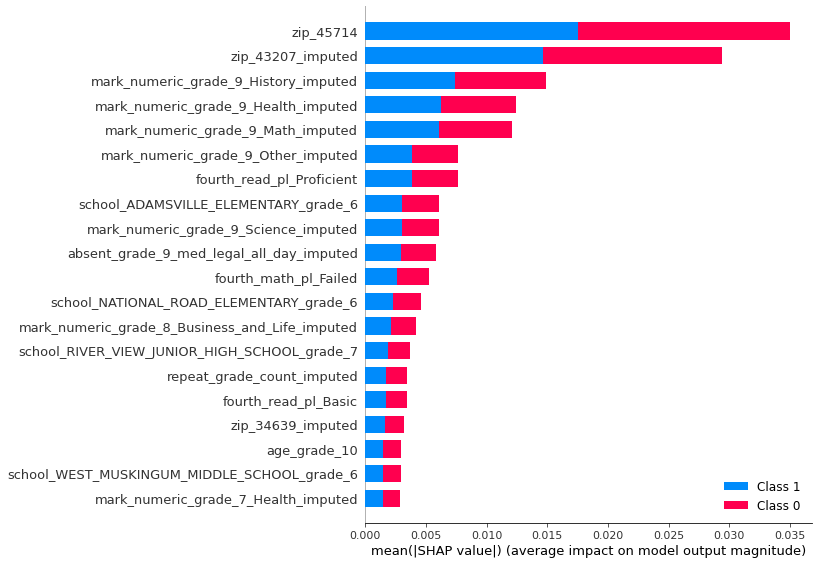

In [29]:
shap.summary_plot(shap_values, X)

In [43]:
# plot the SHAP values for the Setosa output of the first instance
shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], X.iloc[0,:])

# Lime options

In [ ]:
def lime(path, yr):
    X, y, model = fetch_data(path, yr)
    explainer = shap.explainers.other.LimeTabular(
                              X, feature_names = X.columns)
    
    import random

    i = random.randint(1, len(X))

    predict_fn = lambda x: model.predict_proba(x)

    exp = explainer.explain_instance(
                        X[i],
                        predict_fn,
                        num_features=5)

    exp.show_in_notebook(show_all = False)

In [50]:
import random
i = random.randint(1, len(X))
predict_fn = lambda x: model.predict_proba(x)

In [60]:
lime_exp = shap.explainers.other.LimeTabular(predict_fn,data=X.to_numpy(dtype=np.float))

ValueError: Number of features of the model must match the input. Model n_features is 1719 and input n_features is 2015 